In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

dataset, info = tfds.load("fashion_mnist", split="train", with_info=True)

def convert(row):
    image = tf.image.convert_image_dtype(row["image"], tf.float32)
    label = tf.cast(row["label"], tf.float32)
    return image, label

batch_size = 32
dataset = dataset.map(convert).batch(batch_size).prefetch(1)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling ~\tensorflow_datasets\fashion_mnist\3.0.1.incompleteZJ1ZG0\fashion_mnist-train.tfrecord*...:   0%|  …

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling ~\tensorflow_datasets\fashion_mnist\3.0.1.incompleteZJ1ZG0\fashion_mnist-test.tfrecord*...:   0%|   …

Dataset fashion_mnist downloaded and prepared to ~\tensorflow_datasets\fashion_mnist\3.0.1. Subsequent calls will reuse this data.


In [2]:
def get_generator(latent_dimension):

    # 조건 서브 네트워크 : 조건을 히든 표현으로 인코딩
    condition = tf.keras.layers.Input((1,))
    net = tf.keras.layers.Dense(32, activation=tf.nn.elu)(condition)
    net = tf.keras.layers.Dense(64, activation=tf.nn.elu)(net)

    # 히든 조건 표현을 노이즈와 업샘플에 연결
    noise = tf.keras.layers.Input(latent_dimension)
    inputs = tf.keras.layers.Concatenate()([noise, net])

    # Convert inputs from (batch_size, latent_dimension + 1)
    # (batch_size, latent_dimenstion _ 1)인 inputs를
    # 컨볼루션을 사용할 수 있는 4차원 텐서로 변경
    inputs = tf.keras.layers.Reshape((1, 1, inputs.shape[-1]))(inputs)

    depth = 128
    kernel_size = 5
    net = tf.keras.layers.Conv2DTranspose(
        depth, kernel_size, padding="valid", strides=1, activation=tf.nn.relu
    )(
        inputs
    )  # 5x5
    net = tf.keras.layers.Conv2DTranspose(
        depth // 2, kernel_size, padding="valid", strides=2, activation=tf.nn.relu
    )(
        net
    )  # 13x13
    net = tf.keras.layers.Conv2DTranspose(
        depth // 4,
        kernel_size,
        padding="valid",
        strides=2,
        activation=tf.nn.relu,
        use_bias=False,
    )(
        net
    )  # 29x29
    # 28x28x1 출력을 얻기 위해 2x2 커널과의 표준 컨볼루션
    # 이미지가 [0, 1] 범위에 있기 때문에 출력은 sigmoid를 사용한다.
    net = tf.keras.layers.Conv2D(
        1, 2, padding="valid", strides=1, activation=tf.nn.sigmoid, use_bias=False
    )(net)
    model = tf.keras.Model(inputs=[noise, condition], outputs=net)
    return model

In [3]:
def get_discriminator():
    # 인코더 서브네트워크 : 피처 벡터를 얻는 피처 추출기
    image = tf.keras.layers.Input((28, 28, 1))
    depth = 32
    kernel_size = 3
    net = tf.keras.layers.Conv2D(
        depth, kernel_size, padding="same", strides=2, activation=tf.nn.relu
    )(
        image
    )  # 14x14x32
    net = tf.keras.layers.Conv2D(
        depth * 2, kernel_size, padding="same", strides=2, activation=tf.nn.relu
    )(
        net
    )  # 7x7x64

    net = tf.keras.layers.Conv2D(
        depth * 3, kernel_size, padding="same", strides=2, activation=tf.nn.relu
    )(
        net
    )  # 4x4x96

    feature_vector = tf.keras.layers.Flatten()(net)  # 4*4*96

    # 조건에 관한 히든 표현 만들기
    condition = tf.keras.layers.Input((1,))
    hidden = tf.keras.layers.Dense(32, activation=tf.nn.elu)(condition)
    hidden = tf.keras.layers.Dense(64, activation=tf.nn.elu)(hidden)

    # 피처 벡터와 히든 레이블 표현 연결
    out = tf.keras.layers.Concatenate()([feature_vector, hidden])

    # 단일 선형 뉴런으로 이뤄진 최종 분류 레이어 추가
    out = tf.keras.layers.Dense(128, activation=tf.nn.relu)(out)
    out = tf.keras.layers.Dense(1)(out)

    model = tf.keras.Model(inputs=[image, condition], outputs=out)
    return model

In [4]:
bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)


def d_loss(d_real, d_fake):
    """판별기 손실함수"""
    return bce(tf.ones_like(d_real), d_real) + bce(tf.zeros_like(d_fake), d_fake)


def g_loss(generated_output):
    """생성기 손실함수"""
    return bce(tf.ones_like(generated_output), generated_output)

In [5]:
latent_dimension = 100
G = get_generator(latent_dimension)
D = get_discriminator()

def train():
    # 옵티마이저 및 학습 연산을 정의한다.
    optimizer = tf.keras.optimizers.Adam(1e-5)

    @tf.function
    def train_step(image, label):
        with tf.GradientTape(persistent=True) as tape:
            noise_vector = tf.random.normal(
                mean=0, stddev=1, shape=(image.shape[0], latent_dimension)
            )
            # 생성기에서 샘플링
            fake_data = G([noise_vector, label])
            # D 손실 게산
            d_fake_data = D([fake_data, label])
            d_real_data = D([image, label])

            d_loss_value = d_loss(d_real_data, d_fake_data)
            # G 손실 계산
            g_loss_value = g_loss(d_fake_data)
        # 이제 손실을 계산했으므로 그래디언트를 계산하고
        # 네트워크를 최적화할 수 있다.
        d_gradients = tape.gradient(d_loss_value, D.trainable_variables)
        g_gradients = tape.gradient(g_loss_value, G.trainable_variables)
        # 테이프를 영구로 정의했기 때문에 테이프 삭제
        del tape

        optimizer.apply_gradients(zip(d_gradients, D.trainable_variables))
        optimizer.apply_gradients(zip(g_gradients, G.trainable_variables))
        return g_loss_value, d_loss_value, fake_data[0], label[0]

    epochs = 50
    for epoch in range(epochs):
        for image, label in dataset:
            g_loss_value, d_loss_value, generated, condition = train_step(image, label)
        print("epoch ", epoch, "complete")
        print("loss:", g_loss_value, "d_loss: ", d_loss_value)
        print(
            "condition ",
            info.features["label"].int2str(
                tf.squeeze(tf.cast(condition, tf.int32)).numpy()
            ),
        )
        plt.imshow(tf.squeeze(generated).numpy(), cmap="gray")
        plt.show()

epoch  0 complete
loss: tf.Tensor(1.6476257, shape=(), dtype=float32) d_loss:  tf.Tensor(0.37965757, shape=(), dtype=float32)
condition  Dress


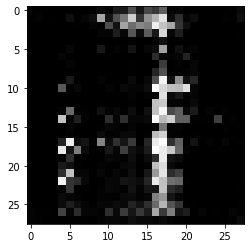

epoch  1 complete
loss: tf.Tensor(2.989687, shape=(), dtype=float32) d_loss:  tf.Tensor(0.0834243, shape=(), dtype=float32)
condition  Dress


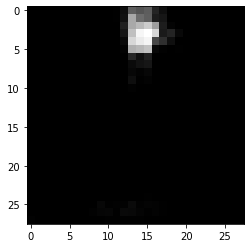

epoch  2 complete
loss: tf.Tensor(1.6398118, shape=(), dtype=float32) d_loss:  tf.Tensor(0.31006426, shape=(), dtype=float32)
condition  Dress


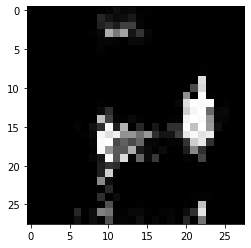

epoch  3 complete
loss: tf.Tensor(2.3310409, shape=(), dtype=float32) d_loss:  tf.Tensor(0.5151919, shape=(), dtype=float32)
condition  Dress


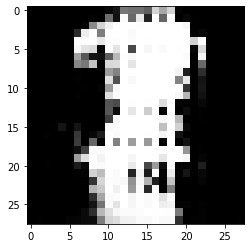

epoch  4 complete
loss: tf.Tensor(2.6242013, shape=(), dtype=float32) d_loss:  tf.Tensor(0.38329306, shape=(), dtype=float32)
condition  Dress


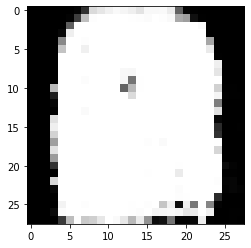

epoch  5 complete
loss: tf.Tensor(2.5259206, shape=(), dtype=float32) d_loss:  tf.Tensor(0.16694896, shape=(), dtype=float32)
condition  Dress


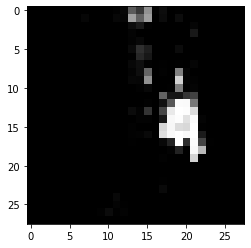

epoch  6 complete
loss: tf.Tensor(3.0761495, shape=(), dtype=float32) d_loss:  tf.Tensor(0.17122507, shape=(), dtype=float32)
condition  Dress


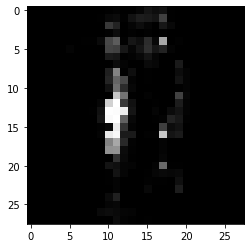

epoch  7 complete
loss: tf.Tensor(2.1303854, shape=(), dtype=float32) d_loss:  tf.Tensor(0.9619704, shape=(), dtype=float32)
condition  Dress


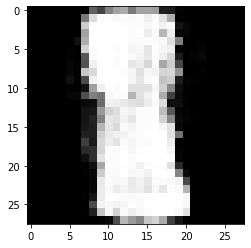

epoch  8 complete
loss: tf.Tensor(1.7777104, shape=(), dtype=float32) d_loss:  tf.Tensor(0.6707136, shape=(), dtype=float32)
condition  Dress


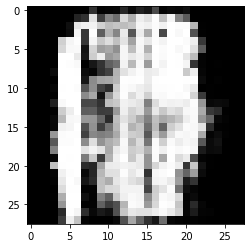

epoch  9 complete
loss: tf.Tensor(1.9279827, shape=(), dtype=float32) d_loss:  tf.Tensor(0.5897152, shape=(), dtype=float32)
condition  Dress


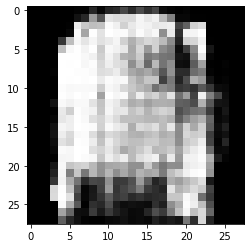

epoch  10 complete
loss: tf.Tensor(1.803256, shape=(), dtype=float32) d_loss:  tf.Tensor(0.5450879, shape=(), dtype=float32)
condition  Dress


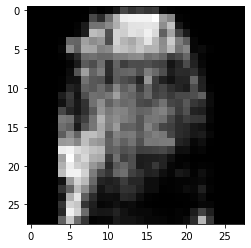

epoch  11 complete
loss: tf.Tensor(1.7822534, shape=(), dtype=float32) d_loss:  tf.Tensor(0.4669433, shape=(), dtype=float32)
condition  Dress


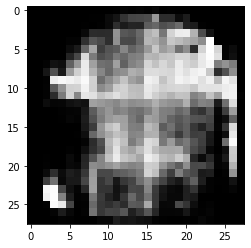

epoch  12 complete
loss: tf.Tensor(3.0177598, shape=(), dtype=float32) d_loss:  tf.Tensor(0.35256213, shape=(), dtype=float32)
condition  Dress


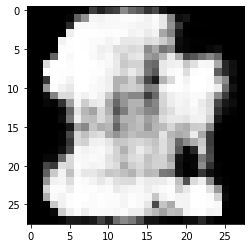

epoch  13 complete
loss: tf.Tensor(1.7345235, shape=(), dtype=float32) d_loss:  tf.Tensor(0.5193177, shape=(), dtype=float32)
condition  Dress


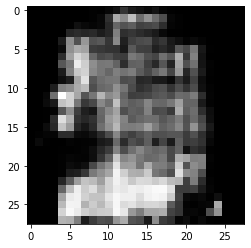

epoch  14 complete
loss: tf.Tensor(1.6095437, shape=(), dtype=float32) d_loss:  tf.Tensor(0.67312753, shape=(), dtype=float32)
condition  Dress


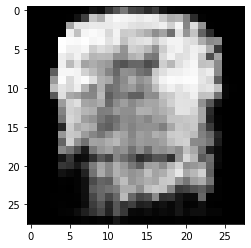

epoch  15 complete
loss: tf.Tensor(1.5778071, shape=(), dtype=float32) d_loss:  tf.Tensor(0.5719682, shape=(), dtype=float32)
condition  Dress


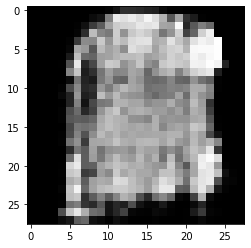

epoch  16 complete
loss: tf.Tensor(1.4732845, shape=(), dtype=float32) d_loss:  tf.Tensor(0.57217497, shape=(), dtype=float32)
condition  Dress


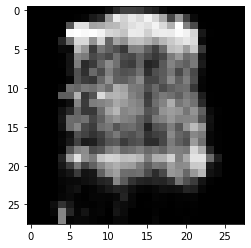

epoch  17 complete
loss: tf.Tensor(1.6990192, shape=(), dtype=float32) d_loss:  tf.Tensor(0.41339362, shape=(), dtype=float32)
condition  Dress


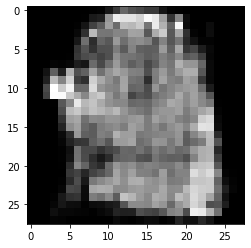

epoch  18 complete
loss: tf.Tensor(1.866473, shape=(), dtype=float32) d_loss:  tf.Tensor(0.4625854, shape=(), dtype=float32)
condition  Dress


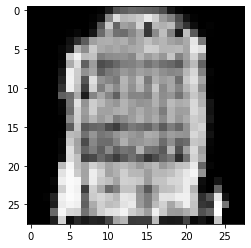

epoch  19 complete
loss: tf.Tensor(1.9638343, shape=(), dtype=float32) d_loss:  tf.Tensor(0.4211197, shape=(), dtype=float32)
condition  Dress


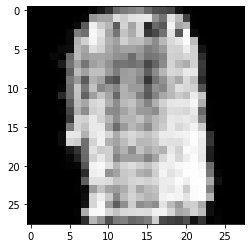

epoch  20 complete
loss: tf.Tensor(1.5097451, shape=(), dtype=float32) d_loss:  tf.Tensor(0.5774454, shape=(), dtype=float32)
condition  Dress


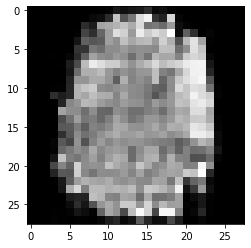

epoch  21 complete
loss: tf.Tensor(1.0889719, shape=(), dtype=float32) d_loss:  tf.Tensor(0.8014337, shape=(), dtype=float32)
condition  Dress


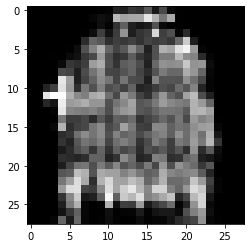

epoch  22 complete
loss: tf.Tensor(1.2900183, shape=(), dtype=float32) d_loss:  tf.Tensor(0.78941566, shape=(), dtype=float32)
condition  Dress


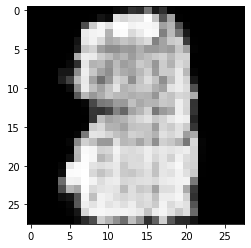

epoch  23 complete
loss: tf.Tensor(1.0371202, shape=(), dtype=float32) d_loss:  tf.Tensor(1.0063328, shape=(), dtype=float32)
condition  Dress


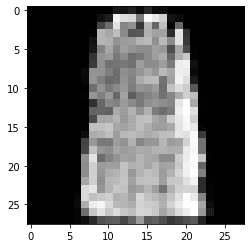

epoch  24 complete
loss: tf.Tensor(0.9839356, shape=(), dtype=float32) d_loss:  tf.Tensor(0.895312, shape=(), dtype=float32)
condition  Dress


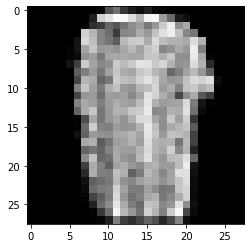

epoch  25 complete
loss: tf.Tensor(0.886001, shape=(), dtype=float32) d_loss:  tf.Tensor(1.0197437, shape=(), dtype=float32)
condition  Dress


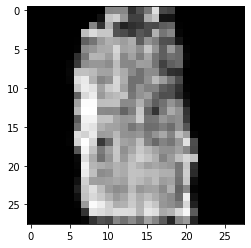

epoch  26 complete
loss: tf.Tensor(0.95237947, shape=(), dtype=float32) d_loss:  tf.Tensor(1.0423493, shape=(), dtype=float32)
condition  Dress


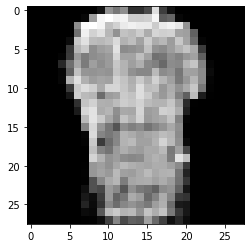

epoch  27 complete
loss: tf.Tensor(0.9452991, shape=(), dtype=float32) d_loss:  tf.Tensor(1.056274, shape=(), dtype=float32)
condition  Dress


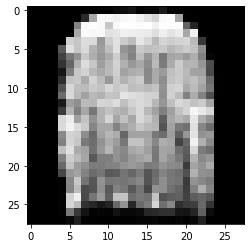

epoch  28 complete
loss: tf.Tensor(0.91414434, shape=(), dtype=float32) d_loss:  tf.Tensor(1.0922472, shape=(), dtype=float32)
condition  Dress


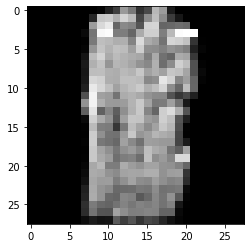

epoch  29 complete
loss: tf.Tensor(0.823924, shape=(), dtype=float32) d_loss:  tf.Tensor(1.1104686, shape=(), dtype=float32)
condition  Dress


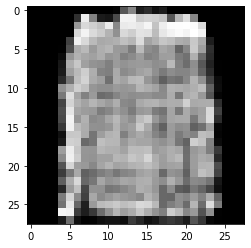

epoch  30 complete
loss: tf.Tensor(0.8108507, shape=(), dtype=float32) d_loss:  tf.Tensor(1.1945431, shape=(), dtype=float32)
condition  Dress


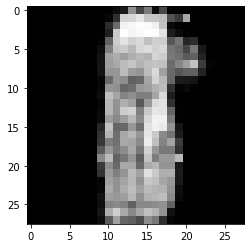

epoch  31 complete
loss: tf.Tensor(0.8163264, shape=(), dtype=float32) d_loss:  tf.Tensor(1.115212, shape=(), dtype=float32)
condition  Dress


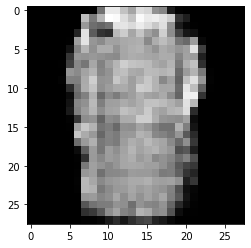

epoch  32 complete
loss: tf.Tensor(0.81663936, shape=(), dtype=float32) d_loss:  tf.Tensor(1.2240243, shape=(), dtype=float32)
condition  Dress


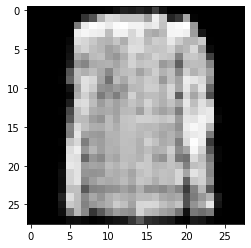

epoch  33 complete
loss: tf.Tensor(0.9869771, shape=(), dtype=float32) d_loss:  tf.Tensor(1.0969796, shape=(), dtype=float32)
condition  Dress


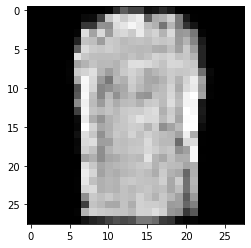

epoch  34 complete
loss: tf.Tensor(0.90919584, shape=(), dtype=float32) d_loss:  tf.Tensor(1.0505468, shape=(), dtype=float32)
condition  Dress


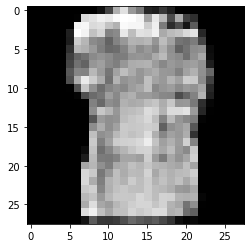

epoch  35 complete
loss: tf.Tensor(0.9424771, shape=(), dtype=float32) d_loss:  tf.Tensor(1.060077, shape=(), dtype=float32)
condition  Dress


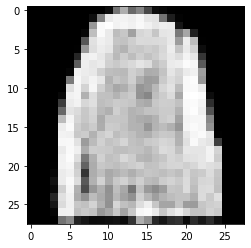

epoch  36 complete
loss: tf.Tensor(0.9004476, shape=(), dtype=float32) d_loss:  tf.Tensor(1.0744697, shape=(), dtype=float32)
condition  Dress


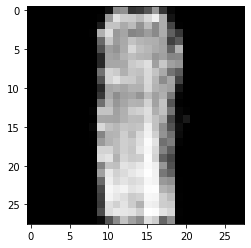

epoch  37 complete
loss: tf.Tensor(0.8504229, shape=(), dtype=float32) d_loss:  tf.Tensor(1.0560304, shape=(), dtype=float32)
condition  Dress


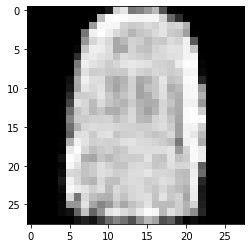

epoch  38 complete
loss: tf.Tensor(0.9225523, shape=(), dtype=float32) d_loss:  tf.Tensor(0.97596097, shape=(), dtype=float32)
condition  Dress


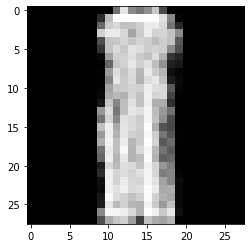

epoch  39 complete
loss: tf.Tensor(1.0154005, shape=(), dtype=float32) d_loss:  tf.Tensor(0.9972759, shape=(), dtype=float32)
condition  Dress


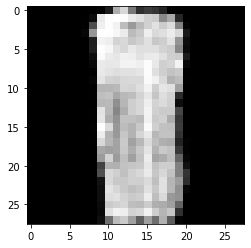

epoch  40 complete
loss: tf.Tensor(0.88735485, shape=(), dtype=float32) d_loss:  tf.Tensor(1.0253285, shape=(), dtype=float32)
condition  Dress


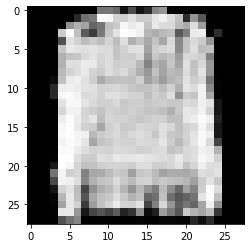

epoch  41 complete
loss: tf.Tensor(0.8532224, shape=(), dtype=float32) d_loss:  tf.Tensor(1.0689722, shape=(), dtype=float32)
condition  Dress


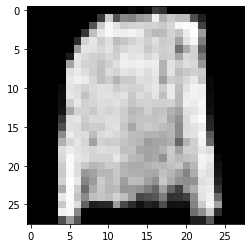

epoch  42 complete
loss: tf.Tensor(1.3136904, shape=(), dtype=float32) d_loss:  tf.Tensor(0.9256021, shape=(), dtype=float32)
condition  Dress


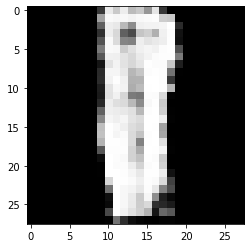

epoch  43 complete
loss: tf.Tensor(0.87804115, shape=(), dtype=float32) d_loss:  tf.Tensor(1.0336224, shape=(), dtype=float32)
condition  Dress


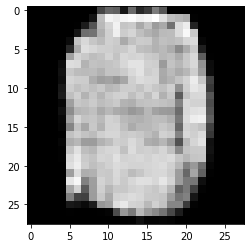

epoch  44 complete
loss: tf.Tensor(0.9193144, shape=(), dtype=float32) d_loss:  tf.Tensor(1.0459052, shape=(), dtype=float32)
condition  Dress


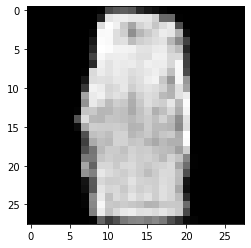

epoch  45 complete
loss: tf.Tensor(1.1861413, shape=(), dtype=float32) d_loss:  tf.Tensor(0.80507004, shape=(), dtype=float32)
condition  Dress


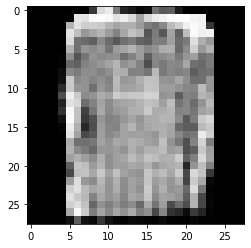

epoch  46 complete
loss: tf.Tensor(1.133976, shape=(), dtype=float32) d_loss:  tf.Tensor(0.9794764, shape=(), dtype=float32)
condition  Dress


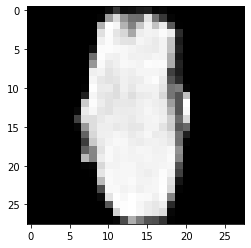

epoch  47 complete
loss: tf.Tensor(0.93243384, shape=(), dtype=float32) d_loss:  tf.Tensor(1.0461441, shape=(), dtype=float32)
condition  Dress


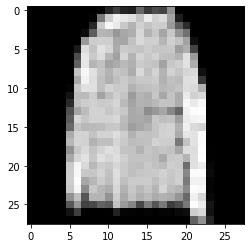

epoch  48 complete
loss: tf.Tensor(0.83641803, shape=(), dtype=float32) d_loss:  tf.Tensor(1.0956986, shape=(), dtype=float32)
condition  Dress


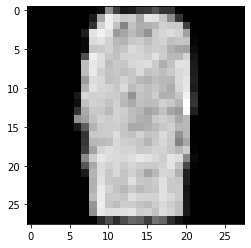

epoch  49 complete
loss: tf.Tensor(1.0971262, shape=(), dtype=float32) d_loss:  tf.Tensor(0.9929279, shape=(), dtype=float32)
condition  Dress


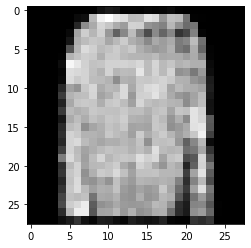

In [6]:
train()